In [1]:
import os, glob, sys
import numpy as np
import pandas as pd
from skimage import io, exposure
from matplotlib import pyplot as plt
from scipy.misc import imresize

os.environ["CUDA_VISIBLE_DEVICES"]="7"

sys.path.append('/data1/pengchengtao/Chest X-ray disease/lung-segmentation-2d/custom_segment/Pytorch-UNet-master/')
from unet import UNet

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
print UNet

<class 'unet.unet_model.UNet'>


In [2]:
ALL_DATA = glob.glob('/data1/pengchengtao/Chest X-ray disease/lung-segmentation-2d/custom_segment/JSRT/Data/*.png')

from sklearn.cross_validation import train_test_split
X_train, X_test, _, _ = train_test_split(ALL_DATA, ALL_DATA, test_size=0.2, random_state=42)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from keras.preprocessing.image import ImageDataGenerator

import cv2, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset


def set_generator():
    data_gen_args = dict(featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=20.,
                    fill_mode='constant',
                    cval=0.,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=False,
                    data_format='channels_first')
    return ImageDataGenerator(**data_gen_args)

class ChestDataset_unet(Dataset):
    def __init__(self, file_list, phase=None, IMG_SIZE=512):
        self.IMG_SIZE = IMG_SIZE
        self.phase, self.file_list = phase, file_list
        
        self.datagen = set_generator()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
    def __getitem__(self, index):
        seed = random.randint(1, 100000)
        img = self.normalize_data(self.file_list[index])
        mask_img = self.get_mask(self.file_list[index])
        if self.phase == 'train':
            for img_data in self.datagen.flow(img[np.newaxis, ...], batch_size=1, seed=seed): break
            img = img_data[0, ...]
            
            mask_img = self.mask_transform(mask_img, seed)
            
            return img.astype(np.float32), mask_img.astype(np.int64)
        
        else:
            return img.astype(np.float32), mask_img.astype(np.int64)
        
    def mask_transform(self, data, seed):
        data_shape = data.shape
        temp = np.zeros(data_shape)
        for i in range(data_shape[0]):
            for mask_data in self.datagen.flow(data[[i], np.newaxis, ...], batch_size=1, seed=seed): break
            temp[i, ...] = mask_data[:, 0, ...]
        return temp
    
    def normalize_data(self, path):
        data = cv2.imread(path)
        data = exposure.equalize_hist(data)
        data = cv2.resize(data, (self.IMG_SIZE, self.IMG_SIZE))
        return data.transpose(2, 0, 1)
    
    def get_mask(self, path):
        mask_path = path.replace('Data', 'Label').replace('.png', '_mask.npy')
        mask_img = np.load(mask_path).transpose(0, 1, 2)
        mask_img = imresize(mask_img, (self.IMG_SIZE, self.IMG_SIZE))
        return mask_img.astype(bool).transpose(2, 0, 1)[:2, ...]
    
    def __len__(self):
        return len(self.file_list)

Using TensorFlow backend.


In [4]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x, is_volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    if is_volatile:
        return Variable(x, volatile=True)
    else:
        return Variable(x)

In [5]:
num_epochs = 1500
batch_size = 4
num_workers = 8
root_path = '/data1/pengchengtao/Chest X-ray disease/Chest_x_ray8/images/'

trainset = ChestDataset_unet(file_list=X_train, phase='train')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valset = ChestDataset_unet(file_list=X_test, phase='val')
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
class Weight_Balance_BCE(nn.Module):
    def __init__(self, weights=None):
        super(Weight_Balance_BCE, self).__init__()
        self.weights = weights
    def forward(self, output, target):
        if self.weights is not None:
            assert len(self.weights) == 2

            loss = self.weights[1] * (target * torch.log(output)) + \
                   self.weights[0] * ((1 - target) * torch.log(1 - output))
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [7]:
from torch import optim
from myloss import *
from torch.optim.lr_scheduler import *

net = UNet(3, 2)

In [8]:
if torch.cuda.is_available():
    net.cuda()
# criterion = nn.BCELoss().cuda()
criterion = DiceLoss().cuda()
learning_rate = 0.0001
# optimizer =  torch.optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

In [9]:
def calcalate_dice(outputs, labels):
    y_pred = F.sigmoid(outputs).float()
    labels = labels.type(torch.ByteTensor).cuda().float()
    
    heart_dice = dice_coeff(y_pred[:, 0, ...], labels[:, 0, ...]).data[0]
    lung_dice = dice_coeff(y_pred[:, 1, ...], labels[:, 1, ...]).data[0]
#     clavicle_dice = dice_coeff(y_pred[:, 2, ...], labels[:, 2, ...]).data[0]
    
    return heart_dice, lung_dice#, clavicle_dice

def eval(net, valloader, step):
    net.eval()
    total_loss = 0.0
    total_dice = []
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = to_var(inputs, is_volatile=True), to_var(labels, is_volatile=True)

        optimizer.zero_grad()
        outputs = net(inputs)

        
        loss = criterion(outputs, labels.float())
#         probs = F.sigmoid(outputs)
#         probs_flat = probs.view(-1)

#         labels_flat = labels.view(-1)

#         loss = criterion(probs_flat, labels_flat.float())

        total_loss += loss.data[0]
        
        total_dice.append(calcalate_dice(outputs, labels))
        
    total_dice = np.array(total_dice).mean(axis=0)

    print ('Total val loss:{}'.format(total_loss / (i+1)))
    print ('Heart DICE:{}'.format(total_dice[0]))
    print ('Lung DICE:{}'.format(total_dice[1]))
#     print 'Clavicle DICE:{}'.format(total_dice[2])
    return total_loss / (i+1)

In [10]:
step = 0
lossMIN = 100000
for epoch in range(0, num_epochs):
    print ('epoch:' + str(epoch))
    net.train()
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = to_var(inputs), to_var(labels)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels.float())
#         probs = F.sigmoid(outputs)
#         probs_flat = probs.view(-1)

#         labels_flat = labels.view(-1)

#         loss = criterion(probs_flat, labels_flat.float())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data[0]
        
        step += 1
        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d], Loss: %.6f' 
                       %(epoch+1, num_epochs, i+1, len(X_train) / batch_size, total_loss / (i+1)))
    torch.save(net, '/data1/pengchengtao/Chest X-ray disease/lung-segmentation-2d/custom_segment/Models/Unet_epoch_{}_finish.pkl'.format(epoch))        
    
    lossVal = eval(net, valloader, step)
#     scheduler.step(lossVal)
    if lossVal < lossMIN:
        lossMIN = lossVal    
        best_epoch = epoch
        torch.save(net, '/data1/pengchengtao/Chest X-ray disease/lung-segmentation-2d/custom_segment/Models/Best_Unet_epoch_{}.pkl'.format(epoch))            

epoch:0
Epoch [1/1500], Iter [20/49], Loss: 0.618183
Epoch [1/1500], Iter [40/49], Loss: 0.588679
Total val loss:0.5701736991222088
Heart DICE:0.2289258184341284
Lung DICE:0.5938445421365591
epoch:1
Epoch [2/1500], Iter [20/49], Loss: 0.532091
Epoch [2/1500], Iter [40/49], Loss: 0.521109
Total val loss:0.5024224657278794
Heart DICE:0.2851416812493251
Lung DICE:0.6404610092823322
epoch:2
Epoch [3/1500], Iter [20/49], Loss: 0.503396
Epoch [3/1500], Iter [40/49], Loss: 0.503877
Total val loss:0.4913200873595018
Heart DICE:0.29021139786793637
Lung DICE:0.6570652035566477
epoch:3
Epoch [4/1500], Iter [20/49], Loss: 0.483400
Epoch [4/1500], Iter [40/49], Loss: 0.481828
Total val loss:0.4632506874891428
Heart DICE:0.32169792973078215
Lung DICE:0.6705077932431147
epoch:4
Epoch [5/1500], Iter [20/49], Loss: 0.469108
Epoch [5/1500], Iter [40/49], Loss: 0.459183
Total val loss:0.4530252264096187
Heart DICE:0.3287944724926582
Lung DICE:0.6851224486644452
epoch:5
Epoch [6/1500], Iter [20/49], Loss:

Total val loss:0.06481655744405893
Heart DICE:0.8604245736048772
Lung DICE:0.9596491593580979
epoch:43
Epoch [44/1500], Iter [20/49], Loss: 0.057217
Epoch [44/1500], Iter [40/49], Loss: 0.059393
Total val loss:0.06780932041314933
Heart DICE:0.852590221625108
Lung DICE:0.9579592392994807
epoch:44
Epoch [45/1500], Iter [20/49], Loss: 0.056591
Epoch [45/1500], Iter [40/49], Loss: 0.056529
Total val loss:0.06102136923716618
Heart DICE:0.873382779268118
Lung DICE:0.9602098831763635
epoch:45
Epoch [46/1500], Iter [20/49], Loss: 0.062825
Epoch [46/1500], Iter [40/49], Loss: 0.059672
Total val loss:0.06594185645763691
Heart DICE:0.8544178788478558
Lung DICE:0.9622925061445969
epoch:46
Epoch [47/1500], Iter [20/49], Loss: 0.058573
Epoch [47/1500], Iter [40/49], Loss: 0.057256
Total val loss:0.07757732959894034
Heart DICE:0.8241193569623507
Lung DICE:0.9517163450901325
epoch:47
Epoch [48/1500], Iter [20/49], Loss: 0.061213
Epoch [48/1500], Iter [40/49], Loss: 0.063231
Total val loss:0.0627579597

Epoch [86/1500], Iter [20/49], Loss: 0.032914
Epoch [86/1500], Iter [40/49], Loss: 0.032672
Total val loss:0.04056327618085421
Heart DICE:0.9182439767397367
Lung DICE:0.9723622386272137
epoch:86
Epoch [87/1500], Iter [20/49], Loss: 0.034343
Epoch [87/1500], Iter [40/49], Loss: 0.032940
Total val loss:0.081726441016564
Heart DICE:0.7955829959649307
Lung DICE:0.967014729976654
epoch:87
Epoch [88/1500], Iter [20/49], Loss: 0.031123
Epoch [88/1500], Iter [40/49], Loss: 0.033037
Total val loss:0.04349843355325552
Heart DICE:0.9112315544715295
Lung DICE:0.9705722652948819
epoch:88
Epoch [89/1500], Iter [20/49], Loss: 0.032653
Epoch [89/1500], Iter [40/49], Loss: 0.031643
Total val loss:0.037017606771909274
Heart DICE:0.9253513308671805
Lung DICE:0.974784268782689
epoch:89
Epoch [90/1500], Iter [20/49], Loss: 0.031206
Epoch [90/1500], Iter [40/49], Loss: 0.030209
Total val loss:0.03645139015637911
Heart DICE:0.9292141474210299
Lung DICE:0.9743942389121423
epoch:90
Epoch [91/1500], Iter [20/49

Epoch [128/1500], Iter [20/49], Loss: 0.026414
Epoch [128/1500], Iter [40/49], Loss: 0.026612
Total val loss:0.04712752654002263
Heart DICE:0.8834961561056284
Lung DICE:0.9768161315184373
epoch:128
Epoch [129/1500], Iter [20/49], Loss: 0.026203
Epoch [129/1500], Iter [40/49], Loss: 0.026247
Total val loss:0.03320842064343966
Heart DICE:0.9335724803117605
Lung DICE:0.9772979296170748
epoch:129
Epoch [130/1500], Iter [20/49], Loss: 0.027276
Epoch [130/1500], Iter [40/49], Loss: 0.026425
Total val loss:0.033430700118725114
Heart DICE:0.93752776659452
Lung DICE:0.975703986791464
epoch:130
Epoch [131/1500], Iter [20/49], Loss: 0.026438
Epoch [131/1500], Iter [40/49], Loss: 0.026306
Total val loss:0.03429943323135376
Heart DICE:0.9294863526637738
Lung DICE:0.9770417030041034
epoch:131
Epoch [132/1500], Iter [20/49], Loss: 0.025758
Epoch [132/1500], Iter [40/49], Loss: 0.026678
Total val loss:0.04583517863200261
Heart DICE:0.8918656798509451
Lung DICE:0.9741026850847098
epoch:132
Epoch [133/1

Total val loss:0.034171452889075644
Heart DICE:0.9328321539438688
Lung DICE:0.976424671136416
epoch:169
Epoch [170/1500], Iter [20/49], Loss: 0.026866
Epoch [170/1500], Iter [40/49], Loss: 0.026258
Total val loss:0.03692502700365507
Heart DICE:0.9273581275573144
Lung DICE:0.9746005672674912
epoch:170
Epoch [171/1500], Iter [20/49], Loss: 0.026073
Epoch [171/1500], Iter [40/49], Loss: 0.025550
Total val loss:0.034353439624492936
Heart DICE:0.9282790972636297
Lung DICE:0.977375654073862
epoch:171
Epoch [172/1500], Iter [20/49], Loss: 0.024112
Epoch [172/1500], Iter [40/49], Loss: 0.025209
Total val loss:0.03166221196834858
Heart DICE:0.9384127488503089
Lung DICE:0.9776260119218093
epoch:172
Epoch [173/1500], Iter [20/49], Loss: 0.024671
Epoch [173/1500], Iter [40/49], Loss: 0.024465
Total val loss:0.032234485332782455
Heart DICE:0.9363818856386038
Lung DICE:0.9775839402125432
epoch:173
Epoch [174/1500], Iter [20/49], Loss: 0.025020
Epoch [174/1500], Iter [40/49], Loss: 0.024790
Total val

Epoch [211/1500], Iter [20/49], Loss: 0.025380
Epoch [211/1500], Iter [40/49], Loss: 0.025055
Total val loss:0.039071775399721585
Heart DICE:0.9069249813373272
Lung DICE:0.9776232701081496
epoch:211
Epoch [212/1500], Iter [20/49], Loss: 0.023015
Epoch [212/1500], Iter [40/49], Loss: 0.024220
Total val loss:0.03438668984633226
Heart DICE:0.9244424792436453
Lung DICE:0.9780302368677579
epoch:212
Epoch [213/1500], Iter [20/49], Loss: 0.026478
Epoch [213/1500], Iter [40/49], Loss: 0.025987
Total val loss:0.038290876608628496
Heart DICE:0.9239411858411936
Lung DICE:0.9733574298711923
epoch:213
Epoch [214/1500], Iter [20/49], Loss: 0.023111
Epoch [214/1500], Iter [40/49], Loss: 0.023150
Total val loss:0.04331188935499925
Heart DICE:0.8876037230858436
Lung DICE:0.9766614895600539
epoch:214
Epoch [215/1500], Iter [20/49], Loss: 0.024004
Epoch [215/1500], Iter [40/49], Loss: 0.023887
Total val loss:0.03233600579775297
Heart DICE:0.9350319871535668
Lung DICE:0.9778305934025691
epoch:215
Epoch [2

Total val loss:0.0335585750066317
Heart DICE:0.9335667628508347
Lung DICE:0.9768233253405645
epoch:252
Epoch [253/1500], Iter [20/49], Loss: 0.023347
Epoch [253/1500], Iter [40/49], Loss: 0.023454
Total val loss:0.03184578510431143
Heart DICE:0.9404286512961755
Lung DICE:0.9768698123785166
epoch:253
Epoch [254/1500], Iter [20/49], Loss: 0.023228
Epoch [254/1500], Iter [40/49], Loss: 0.023448
Total val loss:0.033574892924382135
Heart DICE:0.9365959075781015
Lung DICE:0.975869880272792
epoch:254
Epoch [255/1500], Iter [20/49], Loss: 0.022094
Epoch [255/1500], Iter [40/49], Loss: 0.021793
Total val loss:0.03288414845099816
Heart DICE:0.9346375923890334
Lung DICE:0.9771317472824683
epoch:255
Epoch [256/1500], Iter [20/49], Loss: 0.022133
Epoch [256/1500], Iter [40/49], Loss: 0.021998
Total val loss:0.03382215133080116
Heart DICE:0.9280882431910589
Lung DICE:0.9781177869209876
epoch:256
Epoch [257/1500], Iter [20/49], Loss: 0.022867
Epoch [257/1500], Iter [40/49], Loss: 0.022663
Total val l

Epoch [294/1500], Iter [20/49], Loss: 0.024572
Epoch [294/1500], Iter [40/49], Loss: 0.024473
Total val loss:0.03899570611807016
Heart DICE:0.9076455923227164
Lung DICE:0.9772744408020606
epoch:294
Epoch [295/1500], Iter [20/49], Loss: 0.023880
Epoch [295/1500], Iter [40/49], Loss: 0.023830
Total val loss:0.03384330180975107
Heart DICE:0.9301627415877122
Lung DICE:0.9772984843987685
epoch:295
Epoch [296/1500], Iter [20/49], Loss: 0.024914
Epoch [296/1500], Iter [40/49], Loss: 0.025269
Total val loss:0.03806392504618718
Heart DICE:0.9229648021551279
Lung DICE:0.9745506002352788
epoch:296
Epoch [297/1500], Iter [20/49], Loss: 0.023053
Epoch [297/1500], Iter [40/49], Loss: 0.022893
Total val loss:0.03873682480591994
Heart DICE:0.9122065489108746
Lung DICE:0.9780489756510808
epoch:297
Epoch [298/1500], Iter [20/49], Loss: 0.021923
Epoch [298/1500], Iter [40/49], Loss: 0.022080
Total val loss:0.03467373206065251
Heart DICE:0.9307900346242465
Lung DICE:0.9760185388418344
epoch:298
Epoch [299

Total val loss:0.03259445153749906
Heart DICE:0.9392751180208646
Lung DICE:0.9760678089582003
epoch:335
Epoch [336/1500], Iter [20/49], Loss: 0.022117
Epoch [336/1500], Iter [40/49], Loss: 0.021748
Total val loss:0.04006175352976872
Heart DICE:0.9030669469099778
Lung DICE:0.9765964563076313
epoch:336
Epoch [337/1500], Iter [20/49], Loss: 0.021359
Epoch [337/1500], Iter [40/49], Loss: 0.021449
Total val loss:0.03508482529566838
Heart DICE:0.9256243430651151
Lung DICE:0.976871119095729
epoch:337
Epoch [338/1500], Iter [20/49], Loss: 0.021314
Epoch [338/1500], Iter [40/49], Loss: 0.021557
Total val loss:0.034557108695690446
Heart DICE:0.932031851548415
Lung DICE:0.9758689586932843
epoch:338
Epoch [339/1500], Iter [20/49], Loss: 0.022406
Epoch [339/1500], Iter [40/49], Loss: 0.022433
Total val loss:0.03295665979385376
Heart DICE:0.9357294348570017
Lung DICE:0.9768471947083106
epoch:339
Epoch [340/1500], Iter [20/49], Loss: 0.021663
Epoch [340/1500], Iter [40/49], Loss: 0.021716
Total val l

Epoch [377/1500], Iter [20/49], Loss: 0.020642
Epoch [377/1500], Iter [40/49], Loss: 0.020366
Total val loss:0.04754408964743981
Heart DICE:0.8667566638726455
Lung DICE:0.9771424027589651
epoch:377
Epoch [378/1500], Iter [20/49], Loss: 0.020496
Epoch [378/1500], Iter [40/49], Loss: 0.020772


Process Process-6043:
  File "/home/pengchengtao/pct/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Process Process-6046:
Process Process-6042:
Process Process-6041:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pengchengtao/pct/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "<ipython-input-3-11f811b09cb2>", line 37, in __getitem__
    mask_img = self.get_mask(self.file_list

  File "<ipython-input-3-11f811b09cb2>", line 36, in __getitem__
    img = self.normalize_data(self.file_list[index])
  File "<ipython-input-3-11f811b09cb2>", line 59, in normalize_data
    data = exposure.equalize_hist(data)
  File "/home/pengchengtao/pct/lib/python3.5/site-packages/skimage/exposure/exposure.py", line 168, in equalize_hist
    out = np.interp(image.flat, bin_centers, cdf)
  File "/home/pengchengtao/pct/lib/python3.5/site-packages/numpy/lib/function_base.py", line 2061, in interp
    return interp_func(x, xp, fp, left, right)
KeyboardInterrupt


KeyboardInterrupt: 

In [1]:
# for i, data in enumerate(trainloader, 0):
#     inputs, labels = data
#     inputs, labels = to_var(inputs), to_var(labels)
#     print(inputs)
#     print(labels)

#     optimizer.zero_grad()
#     outputs = net(inputs)
#     print(outputs)
#     loss = criterion(outputs, labels.float())
#     break

# 处理Chest X-ray8数据

In [10]:
import glob, tqdm, cv2, os
import torch

In [11]:
ALL_DATA = glob.glob('/data1/pengchengtao/Chest X-ray disease/Chest_x_ray8/images/*')

In [12]:
net = torch.load('/data1/pengchengtao/Chest X-ray disease/lung-segmentation-2d/custom_segment/Models/Best_Unet_epoch_348.pkl').cuda()

In [14]:
IMG_SIZE = 512
for path in tqdm.tqdm(ALL_DATA):
    data = cv2.imread(path)
    data = exposure.equalize_hist(data)
    data = cv2.resize(data, (IMG_SIZE, IMG_SIZE))
    inputs = to_var(torch.FloatTensor(data.transpose(2, 0, 1)[np.newaxis, ...]), is_volatile=True)
    outputs = net(inputs)
#     print(os.path.join('/data1/pengchengtao/Chest X-ray disease/Chest_Mask/', path.split(os.sep)[-1].replace('.png', '_mask.npy')))
#     break
    np.save(os.path.join('/data1/pengchengtao/Chest X-ray disease/Chest_Mask/', \
            path.split(os.sep)[-1].replace('.png', '_mask.npy')),\
            (F.sigmoid(outputs[0, ...]).data.cpu().numpy()))

100%|██████████| 112120/112120 [3:54:20<00:00,  7.97it/s] 


In [5]:
ALL_DATA = glob.glob('/home/pengchengtao/Desktop/case 4/*.jpg')
print len(ALL_DATA)

99


In [ ]:
IMG_SIZE = 512
for path in tqdm.tqdm(ALL_DATA):
    data = cv2.imread(path)
    data = exposure.equalize_hist(data)
    data = cv2.resize(data, (IMG_SIZE, IMG_SIZE))
    inputs = to_var(torch.FloatTensor(data.transpose(2, 0, 1)[np.newaxis, ...]), is_volatile=True)
    outputs = net(inputs)
#     print(os.path.join('/data1/pengchengtao/Chest X-ray disease/Chest_Mask/', path.split(os.sep)[-1].replace('.png', '_mask.npy')))
#     break
    np.save(os.path.join('/data1/pengchengtao/Chest X-ray disease/Chest_Mask/', \
            path.split(os.sep)[-1].replace('.png', '_mask.npy')),\
            (F.sigmoid(outputs[0, ...]).data.cpu().numpy()))

In [13]:
test=np.load('/data1/pengchengtao/Chest X-ray disease/Chest_Mask/00000001_001_mask.npy')

In [14]:
print(test.shape)

(2, 512, 512)


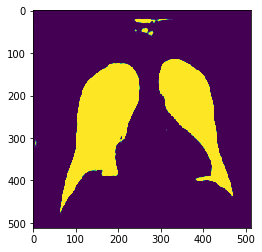

In [31]:
plt.imshow(test[1, ...])